In [ ]:
# make your Google Drive accessible
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive"
drive_data = f"{root_dir}/Colab Notebooks/data/disaster_tweet"

Mounted at /content/gdrive


In [ ]:
# update fastai, according to instructions at https://course.fast.ai/start_colab.html
#!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.text import *
#import fastai; fastai.utils.show_install()

In [ ]:
Config.DEFAULT_CONFIG

{'data_archive_path': '/root/.fastai/data',
 'data_path': '/root/.fastai/data',
 'model_path': '/root/.fastai/models'}

In [ ]:
Config.DEFAULT_CONFIG = {
        'data_path': f'{drive_data}',
        'data_archive_path': f'{drive_data}',
        'model_path': f'{drive_data}' + '/models'
    }

In [ ]:
Config.DEFAULT_CONFIG

{'data_archive_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet',
 'data_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet',
 'model_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet/models'}

In [ ]:
bs=64

In [ ]:
disaster_tweet = f"{drive_data}"; disaster_tweet

'/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet'

In [ ]:
from pathlib import Path

In [ ]:
disaster = Path(disaster_tweet)

In [ ]:
df = pd.read_csv(disaster/'train.csv');df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
len(df)

7613

In [ ]:
 data_lm = (TextList.from_csv(disaster_tweet, csv_name='train.csv', cols='text')
                     .split_by_rand_pct(valid_pct=0.1, seed=42)
                     .label_for_lm()
                     .add_test(TextList.from_csv(disaster_tweet, csv_name='test.csv', cols='text'))
                     .databunch(bs=bs))

In [ ]:
data_lm.save('data_lm_export.pkl')

In [ ]:
data_lm.show_batch()

idx,text
0,orders in xxmaj california xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj
1,are 1 in xxunk . xxbos xxmaj experts in xxmaj france begin examining airplane debris found on xxmaj reunion xxmaj island : xxmaj french air accident experts on xxmaj xxunk ... http : / / t.co / xxunk xxbos xxunk a xxrep 4 w they 're on an airplane accident and they 're gon na die what a xxunk xxrep 4 ? good job ! xxbos family members of xxunk
2,please xxup rt & & sign petition ! xxmaj take a stand & & be a voice for them ! # gilbert23 https : / / t.co / e8dl1lncvu xxbos xxunk xxmaj we need help ! xxmaj horses will xxunk xxup rt & & sign xxunk a stand & & be a voice for them ! # gilbert23 https : / / t.co / e8dl1lncvu xxbos xxmaj stop the xxmaj
3,army # xxmaj beyhive http : / / t.co / o91f3cyy0r 78 xxbos xxmaj one xxmaj direction xxmaj is my pick for http : / / t.co / q2eblokeve xxmaj fan xxmaj army # xxmaj directioners http : / / t.co / encmhz6y34 xxunk xxbos xxmaj you da xxmaj one \n \n # xxunk # xxunk # mtvhottest xxmaj xxunk xxmaj spears xxmaj xxunk xxmaj xxunk xxmaj xxunk xxbos
4,xxmaj waving xxmaj israeli xxmaj flag via xxmaj pamela xxmaj geller - ... http : / / t.co / xxunk xxbos xxmaj christian xxmaj attacked by xxmaj muslims at the xxmaj temple xxmaj mount after xxmaj waving xxmaj israeli xxmaj flag via xxmaj pamela xxmaj geller - ... http : / / t.co / xxunk xxbos xxmaj christian xxmaj attacked by xxmaj muslims at the xxmaj temple xxmaj mount after


In [ ]:
len(data_lm.train_ds.vocab.itos),len(data_lm.test_ds.vocab.itos)

(4264, 4264)

In [ ]:
data_lm.train_ds.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/']

In [ ]:
#data_lm.train_ds.vocab.stoi

## Language Model

In [ ]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)

In [ ]:
%%time
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 12.3 s, sys: 7.24 s, total: 19.6 s
Wall time: 20.4 s


Min numerical gradient: 3.98E-02
Min loss divided by 10: 6.31E-02


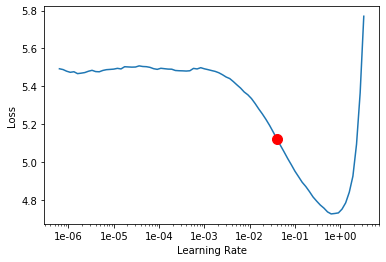

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, 5e-2, moms=(0.8, 0.7))
#learn.save('fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,4.026118,3.238219,0.432857,00:08
1,3.359496,3.127398,0.451027,00:08
2,2.887476,3.053640,0.464420,00:08
3,2.479192,3.047663,0.469063,00:08


In [ ]:
#Unfreeze
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 2.75E-07


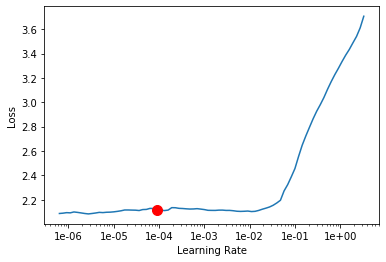

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.142434,3.054295,0.469777,00:08
1,2.127581,3.057683,0.475313,00:08
2,2.040205,3.071307,0.474911,00:08
3,1.932703,3.093842,0.474955,00:08
4,1.847802,3.094602,0.476205,00:08


In [ ]:
#learn.save('fine_tuned')

In [ ]:
#learn.load('fine_tuned')

In [ ]:
TEXT = "The cause for this earthquake is"
N_WORDS = 40
N_SENTENCES = 5

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The cause for this earthquake is the freakiest of freak accidents . Not a # earthquake xxbos What the crew on # Hiroshima were made up http : / / t.co / Nagasaki xxbos The Latest : More homes
The cause for this earthquake is a beautiful disaster in # Jobs xxbos If i have a meltdown i will be in the rubble of my life 
  i feel like my life will go all my fav . # ? ? xxbos
The cause for this earthquake is the most terrifying best roller i have ever seen . xxbos # Myanmar Displaced # Rohingya at # Sittwe point of no return http : / / t.co / Prison like conditions # genocide genocide
The cause for this earthquake is the result of the sinking ship $ 100 m # Earthquake # Sismo m m 1.9 - 5 km s of Volcano Hawaii . Time2015 - 08 - 06 01:04:01 UTC2015 - 08 -
The cause for this earthquake is just beautiful http : / / t.co / qew4c5m1xd View and download video xxbos My attention is in the way of danger of catastrophe . i 'm more upset & & more harm ! ! ! xxbos


In [ ]:
#save the encoder
learn.save_encoder('fine_tuned_enc')

## Classification

In [ ]:
 disaster_tweet

'/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet'

In [ ]:
data_cls = (TextList.from_csv(disaster_tweet, csv_name='train.csv', cols='text', vocab=data_lm.vocab)
            .split_by_rand_pct(valid_pct=0.2, seed=42)
            .label_from_df(cols='target')
            .add_test(TextList.from_csv(disaster_tweet, csv_name='test.csv', cols='text'))
            .databunch(bs=bs))

In [ ]:
#data_cls

In [ ]:
#data_cls.save('data_cls_export.pkl')

In [ ]:
data_cls.show_batch()

text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup xxunk \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n \n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,1


In [ ]:
Config.DEFAULT_CONFIG

{'data_archive_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet',
 'data_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet',
 'model_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet/models'}

In [ ]:
learn = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6091 items)
x: TextList
xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people xxunk # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school,xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires
y: CategoryList
1,1,1,1,1
Path: /content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet;

Valid: LabelList (1522 items)
x: TextList
xxbos xxmaj so you have a new weapon that can cause un - xxunk destruction .,xxbos xxmaj the xxunk things i do for # xxup xxunk xxmaj just got xxunk in a deluge going for xxunk and xxunk . xxmaj thx xxunk @ / @,xxbos xxu

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 2.09E-02


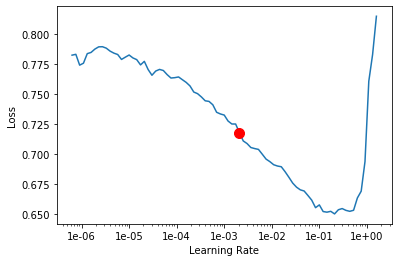

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, max_lr=5e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.585480,0.494104,0.775296,00:08
1,0.536756,0.476610,0.793036,00:08
2,0.506626,0.467518,0.789750,00:09
3,0.503235,0.461664,0.791721,00:08


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-04


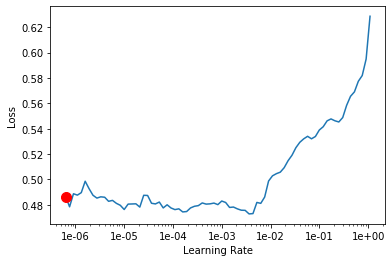

In [ ]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.487228,0.469572,0.791721,00:08
1,0.491562,0.457618,0.792378,00:08
2,0.472099,0.453187,0.794350,00:09
3,0.471907,0.452436,0.792378,00:09


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.32E-07


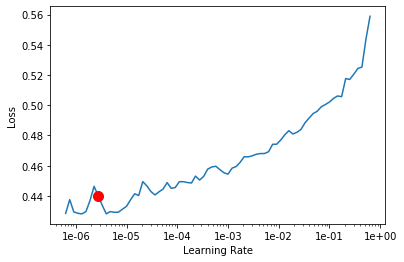

In [ ]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, slice(5e-5/(2.6**4), 5e-5), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.465418,0.463684,0.793693,00:08
1,0.465947,0.453806,0.792378,00:08
2,0.466969,0.458739,0.793693,00:08
3,0.458160,0.454360,0.791721,00:08


In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-05


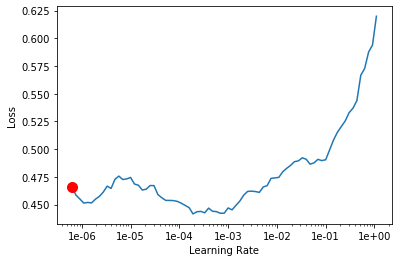

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, slice(5e-5/(2.6**4), 5e-5), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.460316,0.452006,0.789750,00:09
1,0.464922,0.453353,0.789750,00:09
2,0.448429,0.457392,0.792378,00:09
3,0.459876,0.452743,0.789750,00:09


In [ ]:
learn.predict("airplane%20accident,,Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wednesday began examining t...,")


(Category 1, tensor(1), tensor([0.0042, 0.9958]))

In [ ]:
learn.predict("accident,\"Frankfurt, Germany\",@DaveOshry @Soembie So if I say that I met her by accident this week- would you be super jelly Dave? :p")

(Category 0, tensor(0), tensor([0.8688, 0.1312]))

In [ ]:
(predictions, targets) = learn.get_preds(DatasetType.Test)

In [ ]:
predictions

tensor([[0.1541, 0.8459],
        [0.3034, 0.6966],
        [0.3300, 0.6700],
        ...,
        [0.0469, 0.9531],
        [0.5605, 0.4395],
        [0.6978, 0.3022]])

In [ ]:
targets

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
data_cls.classes

[0, 1]

In [ ]:
test = pd.read_csv(f"{disaster_tweet}/test.csv")

In [ ]:
preds = predictions.argmax(dim=-1)
id = test['id']

In [ ]:
my_submission = pd.DataFrame({'id': id, 'target': preds})
my_submission.to_csv('submission.csv', index=False)